In [22]:
from statistics import mean
import json

import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.ticker as mticker
from sklearn.linear_model import LinearRegression

%matplotlib inline

plt.style.use('ggplot') 

def choose_nth_value(lst:list, n:int) -> list[str]:
    '''
        chooses elements in list which indexes divide by N with zero remainders
    '''
    return [val for i, val in enumerate(lst, start=1) if i % n == 0]

def choose_except_nth_value(lst:list, n:int) -> list[str]:
    '''same function as before but for choosing everything *except* nth value'''
    return [val for i, val in enumerate(lst, start=1) if i % n != 0]

def extract_row_values(df,col_name, n, except_value=False) -> list:
    '''
        extracts values of the chosen economic activity row and chooses total data points by years
    '''
    row_values = df.loc[df['Economic Activities'] == col_name].values[0][1:]
    row_values = list(row_values)
    if except_value is True:
        row_values = choose_except_nth_value(row_values,n)
    else:
        row_values = choose_nth_value(row_values,n)
    return row_values

def calculate_growth(row_values):
    previous_val = row_values
    current_val = row_values[1:] 
    growth_rate_list = []
    for i in range(len(current_val)):
        growth_rate_percent = ((current_val[i] - previous_val[i]) / previous_val[i]) * 100
        growth_rate_list.append(growth_rate_percent)
    return growth_rate_list


# GDP

## Total GDP over Years
analyze the GDP data to find out *Market*, *Basic* and *Per Capita* GDP in years 2010-2023

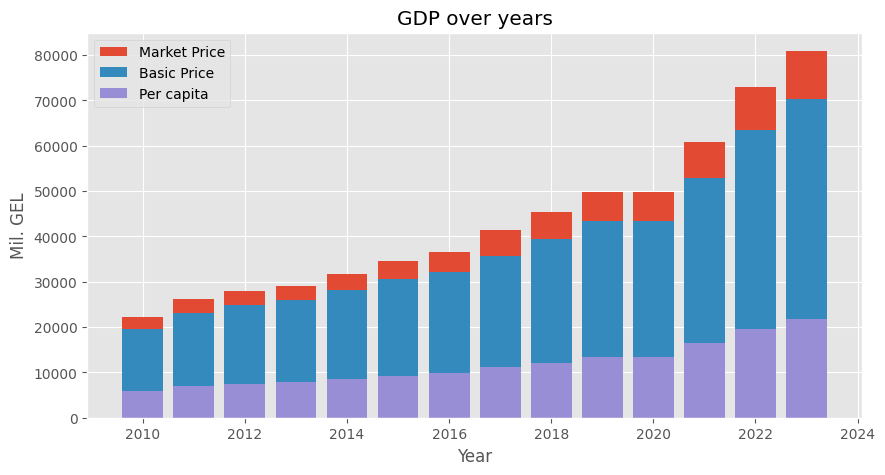

In [2]:
# load dataframe of GDP downloaded from Geostat.ge
df = pd.read_excel('./03_GDP-at-Current-Prices.xlsx')

# columns are not defined properly so we set them manually for this file
df.columns = df.iloc[0]
df = df[1:].reset_index(drop=True)
df.drop(columns=[df.columns[0]],inplace=True)

# last 2 rows contain uneccessary data
df = df.iloc[:-2]

# file contains data about quarters aswell, so we extract every 5th value(which are total for that year)
years = df.columns[1:]
years = list(years)
years = choose_nth_value(years,5)

# we extract market, basic and per capita gdp points
gdp_market_price = extract_row_values(df,'(=) GDP at market prices', 5)
gdp_basic_price = extract_row_values(df,'(=) GDP at basic prices', 5)
gdp_per_capita = extract_row_values(df,'GDP per capita in GEL',5)

# initialize subplots
fig, ax = plt.subplots(figsize=(10,5))

# Plot our data
ax.bar(years,gdp_market_price,label='Market Price')
ax.bar(years, gdp_basic_price,label='Basic Price')
ax.bar(years,gdp_per_capita,label='Per capita')

ax.set_title('GDP over years')
ax.set_xlabel("Year")
ax.set_ylabel("Mil. GEL")

ax.legend(loc='upper left')

plt.show()

## Actual Growth
How much percent was GDP growth every year? is GDP *Per capita* growth rate keeping up with *market* GDP growth rate?

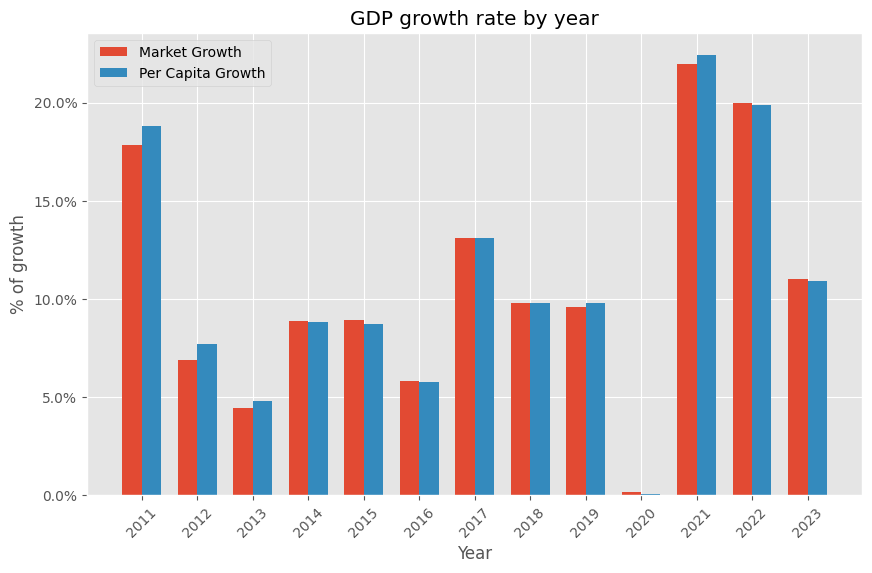

In [3]:
bar_width = 0.35

x = np.arange(len(years[1:]))  # positions for the bars

# calculate market growth for both series
market_growth = calculate_growth(gdp_market_price)
per_capita_growth = calculate_growth(gdp_per_capita)

fig, ax = plt.subplots(figsize=(10,6))

# Plot barcharts of both series next to each other
ax.bar(x - bar_width / 2, market_growth, bar_width, label='Market Growth')
ax.bar(x + bar_width / 2, per_capita_growth, bar_width, label='Per Capita Growth')

ax.set_title('GDP growth rate by year')
ax.set_xlabel("Year")
ax.set_ylabel("% of growth")

ax.set_xticks(x)
ax.set_xticklabels([int(val) for val in years[1:]])
ax.tick_params(axis='x', rotation=45)

# format y labels to percent values 
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(decimals=1))

ax.legend(loc='upper left',ncols=1)


plt.show()


## Main Contributors to GPD growth
Which industries are the main contributors to Georgia's GDP?

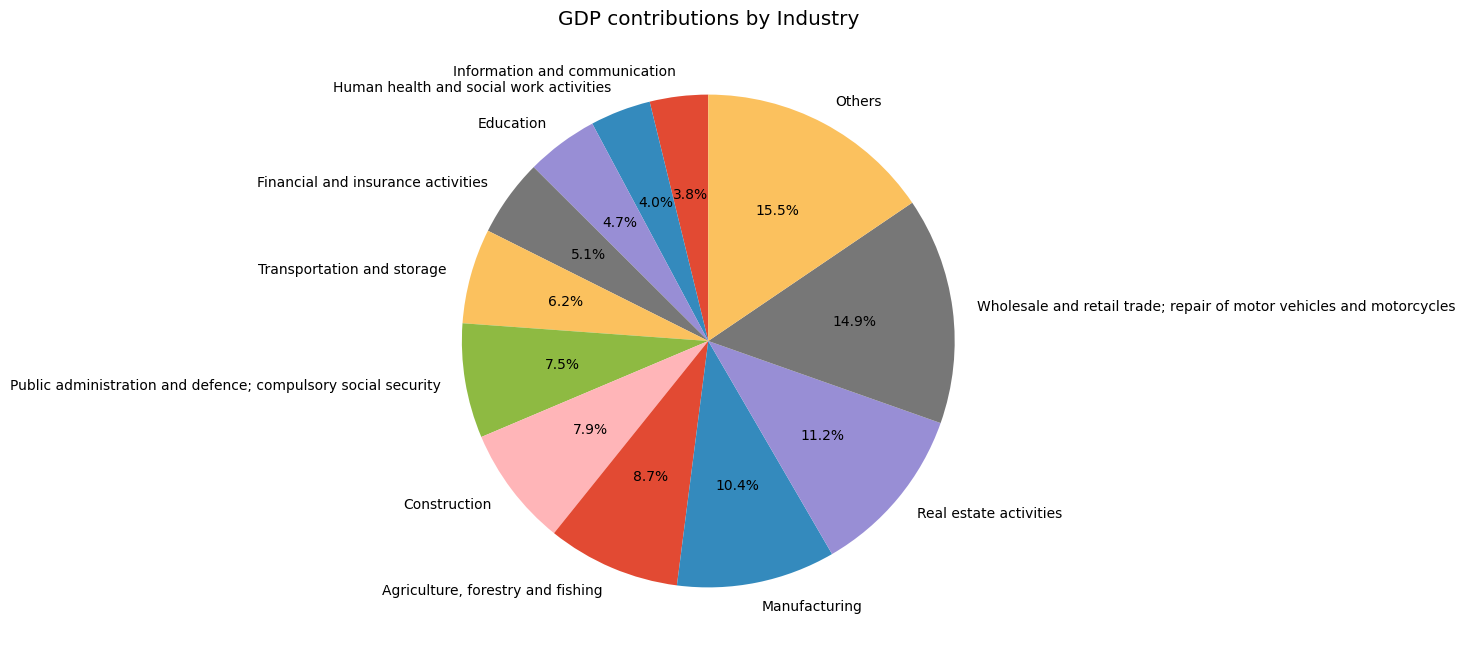

In [4]:
# extract all economic activities
activities_names = df['Economic Activities'][:20].values

# extract each activity values
activity_row_values_list = []
for activity in activities_names:
    activity_row_values = extract_row_values(df,activity,5)
    activity_row_values_list.append(activity_row_values)

# we use mean/average as an indicator for contributions over years (median can also be used) 
contributions_mean = [sum(activity_values) for activity_values in activity_row_values_list]
sizes = [(contributions_mean[i]/sum(contributions_mean))*100 for i in range(len(contributions_mean))]

# since many industries have very little contributions and it is hard to plot them properly
# we need to place them in "others" category
new_sizes = [0]
new_labels = ['Others']
for idx, size in enumerate(sizes):
    if size > 3.5:
        new_sizes.append(size)
        new_labels.append(activities_names[idx])
    else:
        new_sizes[0] += size

# create subplot
fig, ax = plt.subplots(figsize=(10,8))

# place all industries into dataframe
df_contrib = pd.DataFrame({'sizes':new_sizes,'labels':new_labels})

# sort values to beautify chart
df_contrib.sort_values(by=['sizes'],inplace=True)

ax.set_title("GDP contributions by Industry")
ax.pie(df_contrib['sizes'],labels=df_contrib['labels'],autopct='%1.1f%%',startangle=90)

plt.show()


# Inflation and Cost of Living


## What is the exchange rate trend in Georgia over time?

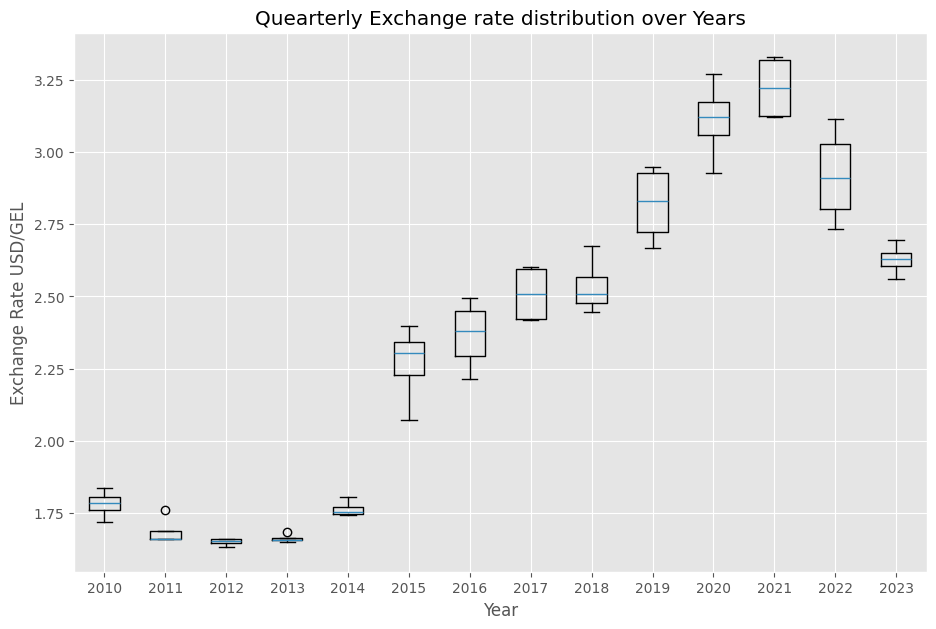

In [5]:
# we want to find out what was exchange rate over years and how volatile was it during quarters
quarters = df.columns[1:]
quarters = list(quarters)
quarters = choose_except_nth_value(quarters,5)
quarters = quarters[:-3]

# extract values of quarters
exchange_rate_values = extract_row_values(df,df['Economic Activities'].iloc[-1], 5, except_value=True)
exchange_rate_values = exchange_rate_values[:-3]


def reshape_to_quarters_box(lst:list):
    '''reshape list to 2d array of 4 elements each'''
    quarters_array = np.array(lst)
    nested_quarters = quarters_array.reshape(-1, 4)
    return nested_quarters

quarters = reshape_to_quarters_box(quarters)
exchange_rate_values = reshape_to_quarters_box(exchange_rate_values)

years = [str(int(year)) for year in years]

fig, ax = plt.subplots(figsize=(11,7))

ax.boxplot(list(exchange_rate_values))
ax.set_xticklabels(years)

ax.set_xlabel("Year")
ax.set_ylabel("Exchange Rate USD/GEL")

ax.set_title("Quearterly Exchange rate distribution over Years")

plt.show()

## what is Inflation Rate and CPI?

### Consumer Price Index
What was Consumer Price index in Georgia from 2004?

C:\Users\Saba\AppData\Local\Temp\ipykernel_3404\1043557261.py:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_cpi = df_cpi[~df_cpi.applymap(lambda x: string_to_remove in str(x)).any(axis=1)]
C:\Users\Saba\AppData\Local\Temp\ipykernel_3404\1043557261.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_price_changes = pd.concat([df_price_changes,df_adjusted_cpi]).reset_index(drop=True)


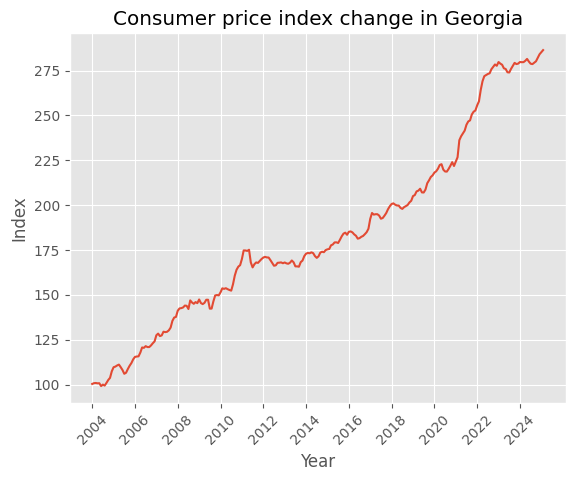

In [18]:
df_cpi = pd.read_excel('CPI.xlsx')
df_cpi.columns = df_cpi.iloc[2]
df_cpi = df_cpi[1:].reset_index(drop=True)
df_cpi.rename(columns={df_cpi.columns[0]:"Groups"},inplace=True)
row_total = df_cpi.loc[2].values[2:]

df_cpi.iloc[1,2] = 'Group'
df_cpi.columns = df_cpi.iloc[1]
df_cpi = df_cpi[4:].reset_index(drop=True)
df_cpi.drop(columns=df_cpi.columns[0],inplace=True)

# name each month in format YYYY_MM
new_col_names = ["Group"]
for year in range(2004,2026):
    for month in range(1,13):
        new_col_names.append(f'{year}_{month}')

# assign column names
df_cpi.columns = new_col_names[:-10]

# New row to insert at index 0
row_total_df = pd.DataFrame([row_total], columns=df_cpi.columns)

# Concatenate and reset index
df_cpi = pd.concat([row_total_df, df_cpi]).reset_index(drop=True)

# String to search for (N/A values are in this format)
string_to_remove = "..."

# Drop rows where any column contains the string
df_cpi = df_cpi[~df_cpi.applymap(lambda x: string_to_remove in str(x)).any(axis=1)]
df_cpi = df_cpi.reset_index(drop=True)

def adjust_cpi(current_month_level:float,previous_month_level:float) -> float:
    ''' adjusts cpi value to previous month instead of base month '''
    return previous_month_level * (current_month_level / 100)

def adjust_cpi_for_row(cpi_row):
    adjusted_cpis = []
    adjusted_cpis.append(cpi_row[0])
    adjusted_cpis.append(cpi_row[1])
    for point_idx in range(2,len(cpi_row)):
        current_month_level = cpi_row[point_idx]
        previous_month_level = adjusted_cpis[point_idx-1]
        adjusted_cpis.append(adjust_cpi(current_month_level,previous_month_level))
    return adjusted_cpis

df_price_changes = pd.DataFrame(columns=df_cpi.columns)
for row_idx in range(len(df_cpi)):
    df_adjusted_cpi = adjust_cpi_for_row(df_cpi.loc[row_idx].values)
    
    df_adjusted_cpi = pd.DataFrame([df_adjusted_cpi], columns=df_cpi.columns)
    df_price_changes = pd.concat([df_price_changes,df_adjusted_cpi]).reset_index(drop=True)
    

# create x indices for data points and extract data points row
x = [i for i in range(len(df_price_changes.columns[1:]))]
y = df_price_changes.loc[0].values[1:]

fig, ax = plt.subplots()

ax.plot(df_price_changes.columns[1:],y)

ax.set_title("Consumer price index change in Georgia")
ax.set_xlabel("Year")
ax.set_ylabel('Index')

# take every 24th month(i.e every second year)
x_ticks = df_price_changes.columns[1:][::24]
# shorten labels for x ticks from format YYYY_MM to YYYY
labels = [year[:-2] for year in df_price_changes.columns[1:][::24]]

plt.xticks(x_ticks, labels,rotation=45)  # Select every 12th x-axis label

plt.show()

### CPI changes
what was the change to price index between 2004-2025 in interested categories?

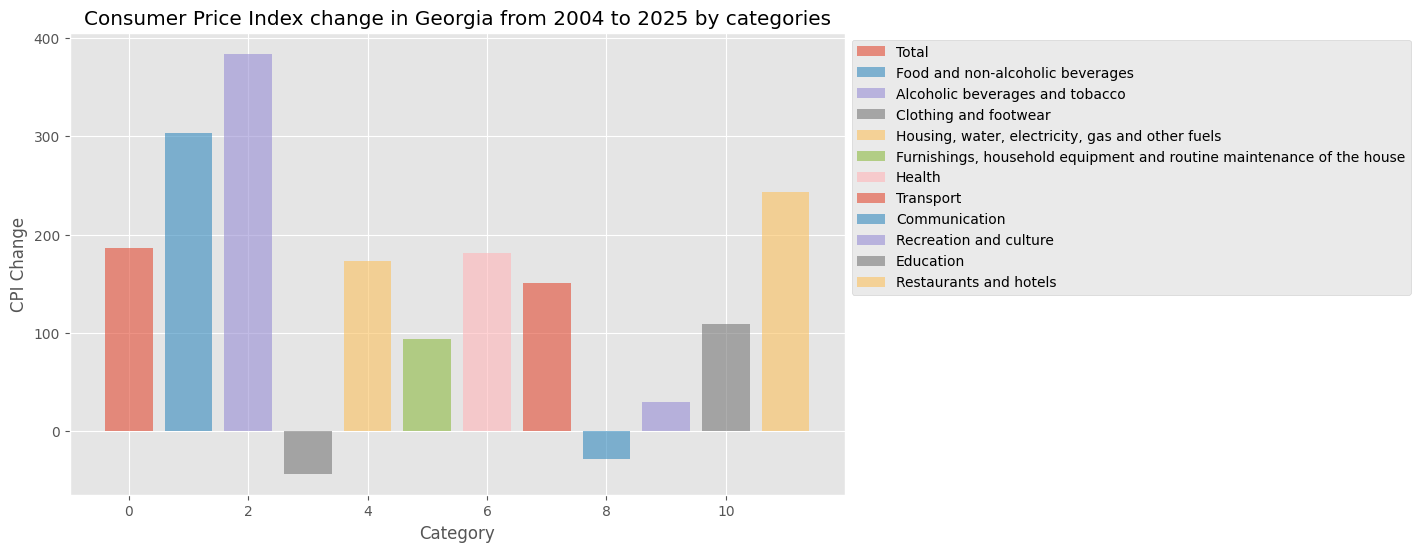

In [ ]:
# define main groups that we are interested in
interested_groups = ['Total',
                     'Food and non-alcoholic beverages',
                     'Alcoholic beverages and tobacco',
                     'Clothing and footwear',
                     'Housing, water, electricity, gas and other fuels',
                     'Furnishings, household equipment and routine maintenance of the house',
                     'Health',
                     'Transport',
                     'Communication',
                     'Recreation and culture',
                     'Education',
                     'Restaurants and hotels'
                     ]

fig, ax = plt.subplots(figsize=(10, 6))

# plot price index differences between 2004 and 2025  
i = 0
for group in interested_groups:
    x = df_price_changes.columns[1:]
    row = list(df_price_changes.loc[df_price_changes['Group'] == group].values[0])
    
    y = row[1:]

    difference = y[-1] - y[0]
    ax.bar(i, difference,alpha=0.6, label=row[0])
    i+=1

ax.set_title("Consumer Price Index change in Georgia from 2004 to 2025 by categories")
ax.set_xlabel("Category")
ax.set_ylabel('CPI Change')

ax.legend(loc='upper left',bbox_to_anchor=(1, 1))

plt.show()

###  Inflation Rate
What was the inflation month every month? What is the rolling mean of the last 1 year of inflation rate?

C:\Users\Saba\AppData\Local\Temp\ipykernel_3404\1462551087.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inflation.iloc[:, 1:] = df_inflation.iloc[:, 1:] - 100


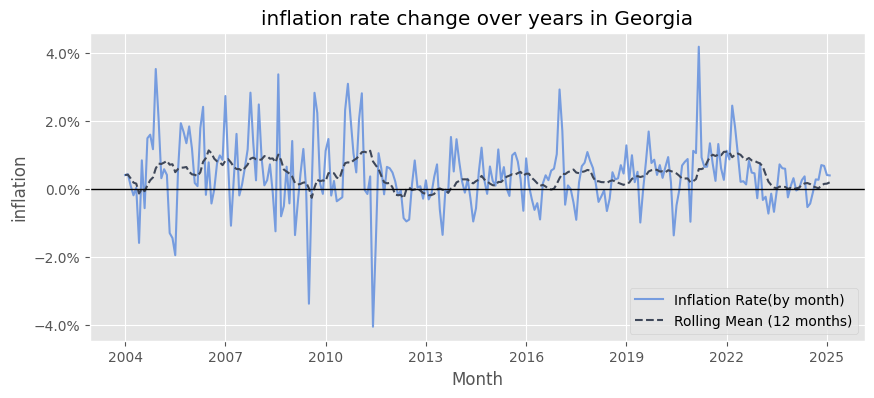

In [21]:
# drop subgroups and leave only main groups
groups_to_drop = [group for group in  df_cpi['Group'].values if group not in interested_groups]
df_inflation = df_cpi[~df_cpi["Group"].isin(groups_to_drop)]

# Subtract 100 from every value except the first column
df_inflation.iloc[:, 1:] = df_inflation.iloc[:, 1:] - 100

# define groups and values to x and y
x = df_inflation.columns[1:]
y = df_inflation.loc[0].values[1:]

# Compute rolling mean with a window size of 12 (adjust as needed)
rolling_mean = pd.Series(y).rolling(window=12, min_periods=1).mean()

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(x,y,label="Inflation Rate(by month)",color='#769CDF')
ax.plot(x, rolling_mean, label='Rolling Mean (12 months)', linestyle='dashed', color='#3e4759')

# show only every third year on x labels
indices = df_inflation.columns[1:][::36]
xtick_labels = [name[:-2] for name in indices]

# add percent sign to y labels
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(decimals=1))

ax.set_title("inflation rate change over years in Georgia")
ax.set_xlabel("Month")
ax.set_ylabel("inflation")

# Add reference line at 0
plt.axhline(y=0, color='black', linewidth=1)

plt.xticks(indices, xtick_labels)  # Select every 36th x-axis label(every third year)
plt.legend()
plt.show()

# Unemployment and Wages


## unemployment rates heatmap
Draw unemployment heatmap to see situation with employment in Georgia

In [23]:

# Load shapefile (replace 'georgia_shapefile.shp' with actual file)
gdf = gpd.read_file("./gadm41_GEO_shp/gadm41_GEO_1.shp")

df_employment_region_2023 = pd.read_csv('2023_employment_regions.csv')
# rename first unnamed column
df_employment_region_2023.rename(columns={df_employment_region_2023.columns[0]:"type"},inplace=True)
# select row with unemployment rates
unemployment_row = df_employment_region_2023.loc[df_employment_region_2023['type'].isin(["Unemployment rate, percentage"])]

# extract region names and unemployment rates for each of the regions
cols = list(unemployment_row.columns)[1:]
unemployment_values = list(unemployment_row.values[0])[1:]

# create dataframe
df_unemp = pd.DataFrame({"region":cols, "rates":unemployment_values})
df_unemp = df_unemp[:-1]

# rename region names to format of map
df_unemp.loc[df_unemp['region'] == 'Adjara A/R', 'region'] = 'Ajaria'
df_unemp.loc[df_unemp['region'] == 'Racha-Lechkhumi and Kvemo-Svaneti', 'region'] = 'Racha-Lechkhumi-Kvemo Svaneti'

# define min and max values to balance colormap because of "N/A" value of Abkhazia
vmin = df_unemp["rates"].min(skipna=True)
vmax = df_unemp["rates"].max(skipna=True)

missing_data = pd.DataFrame({
    "region": ["Abkhazia"],  # List of missing regions
    "rates": [0.0]  #"N/A" value basically
})

df_unemp = pd.concat([df_unemp,missing_data])
df_unemp_renamed = df_unemp.rename(columns={'region':'NAME_1'})
merged_data = gdf.merge(df_unemp_renamed, on="NAME_1")

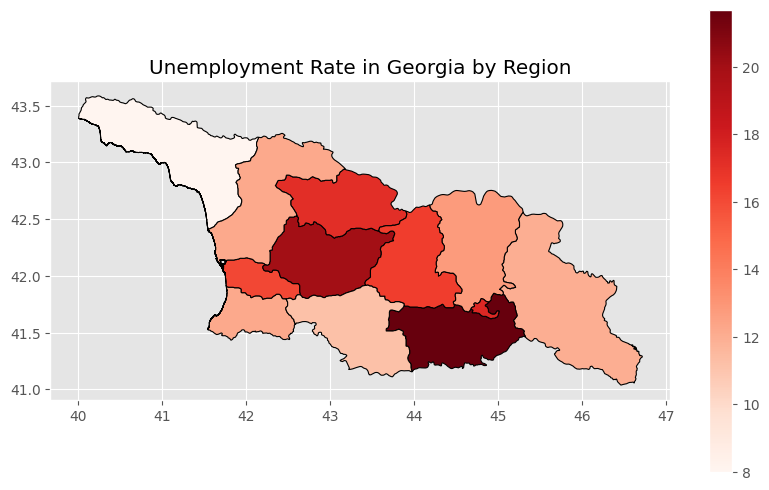

In [24]:
# Plot the heatmap
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
merged_data.plot(column="rates",
                  cmap="Reds",
                  linewidth=0.8,
                  edgecolor="black", # border color
                  legend=True,
                  ax=ax,
                  vmin=8, # set with vmin variable or manually
                  vmax=vmax )
ax.set_title("Unemployment Rate in Georgia by Region")
plt.show()

## Generate interactive map of unemployment rates
We can also generate interactive map with html using folium library 

In [25]:

# Convert GeoDataFrame to GeoJSON
geojson_data = merged_data.to_json()

# Initialize the map
m = folium.Map(location=[42, 43.5], zoom_start=7)

# Choropleth heatmap
folium.Choropleth(
    geo_data=geojson_data,
    name="Unemployment Rate",
    data=merged_data,
    columns=["NAME_1", "rates"], #NAME_1 is region names, rates are unemloyment rates
    key_on="feature.properties.NAME_1", # main feature (regions)
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.01,
    legend_name="Unemployment Rate (%)",
).add_to(m)

# We can also add popup which shows exact percent for region on click
for _, row in merged_data.iterrows():
    # Create a Popup with specific content (region name and unemployment rate)
    popup_content = f"Region: {row['NAME_1']}<br>Unemployment Rate: {row['rates']}%"

    # Create a GeoJson object for the region
    folium.GeoJson(
        row['geometry'],  # The geometry for the region
        popup=folium.Popup(popup_content, max_width=300),
        style_function=lambda x: {'fillColor': 'blue', 'color': 'blue', 'weight': 0}
    ).add_to(m)
    
# Save map to an HTML file and display
m.save("georgia_unemployment_interactive_map.html")

## salary

### Do wages in georgia keep up with inflation rates?

#### Calculate yearly Consumer Price index changes


In [57]:
# Load consumer price index chart and make same operations as before
df_cpi = pd.read_excel('CPI.xlsx')
df_cpi.columns = df_cpi.iloc[2]
df_cpi = df_cpi[1:].reset_index(drop=True)
df_cpi.rename(columns={df_cpi.columns[0]:"Groups"},inplace=True)
row_total = df_cpi.loc[2].values[2:]

df_cpi.iloc[1,2] = 'Group'
df_cpi.columns = df_cpi.iloc[1]
df_cpi = df_cpi[4:].reset_index(drop=True)
df_cpi.drop(columns=df_cpi.columns[0],inplace=True)

new_col_names = ["Group"]
for year in range(2004,2026):
    for month in range(1,13):
        new_col_names.append(f'{year}_{month}')

df_cpi.columns = new_col_names[:-10]

# New row to insert at index 0
row_total_df = pd.DataFrame([row_total], columns=df_cpi.columns)

# Concatenate and reset index
df_cpi = pd.concat([row_total_df, df_cpi]).reset_index(drop=True)

# String to search for
string_to_remove = "..."

# Drop rows where any column contains the string
df_cpi = df_cpi[~df_cpi.applymap(lambda x: string_to_remove in str(x)).any(axis=1)]
df_cpi = df_cpi.reset_index(drop=True)

df_inflation_row = adjust_cpi_for_row(df_cpi.loc[0].values)
yearly_cpi = df_inflation_row[1::12]
   

C:\Users\Saba\AppData\Local\Temp\ipykernel_3404\567036743.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_cpi = df_cpi[~df_cpi.applymap(lambda x: string_to_remove in str(x)).any(axis=1)]


In [58]:
# we have yearly CPI, now we need to load average salaries and predict what was mean
# based on the data of last few years 
df_median_salaries = pd.read_csv('./salary_meadians.csv')
df_avg_salaries = pd.read_csv('./salaries.csv')
df_median_salaries.head()


,type,2018,2019,2020,2021,2022,2023
0,Total,700,792,809,900,1040,1238


In [59]:
df_avg_salaries.head()

,type,1970,1975,1980,1985,1986,1987,1988,1989,1990,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Total,106.1,118.9,145.2,167.6,170.6,177.2,186.9,197.7,214.0,...,818.0,900.4,940.0,999.1,1068.3,1129.5,1191.0,1304.5,1543.0,1766.8


In [60]:
# take values from averages df that are in the first dataframe
cols_to_fetch = list(df_median_salaries.columns)[1:]

# merge dataframes
df_salaries_merged = df_avg_salaries[cols_to_fetch]
df_salaries_merged = pd.concat([df_salaries_merged, df_median_salaries],ignore_index=True)


# drop "type" column
df_salaries_merged = df_salaries_merged.drop(columns=['type'])
df_salaries_merged.reset_index()

,index,2018,2019,2020,2021,2022,2023
0,0,1068.3,1129.5,1191.0,1304.5,1543.0,1766.8
1,1,700.0,792.0,809.0,900.0,1040.0,1238.0


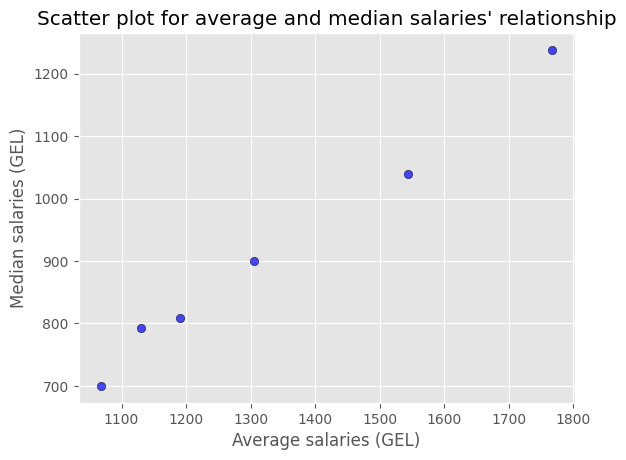

In [61]:
# Let's plot scatterplot to see if there is some visible correlation
x = df_salaries_merged.loc[0]
y = df_salaries_merged.loc[1]

plt.scatter(x, y, color='blue', alpha=0.7, edgecolors='black')


plt.xlabel("Average salaries (GEL)")
plt.ylabel("Median salaries (GEL)")
plt.title("Scatter plot for average and median salaries' relationship")


plt.show()

In [62]:
# Calculate correlation coefficient to be sure that they have correlation
correlation = np.corrcoef(x, y)[0, 1]
print(f"Correlation coefficient: {correlation:.4f}")

Correlation coefficient: 0.9949


In [63]:
# it seems like they have strong correlation,
# now we need to make simple linear regression model to fit this data

X = np.array(x.values).reshape(-1, 1)
Y = np.array(y.values)
# we make linear regression model to predict previous years' data
model = LinearRegression()
model.fit(X,Y)

# Print model coefficients
print(f"Intercept: {model.intercept_:.2f}")
print(f"Slope: {model.coef_[0]:.2f}")

r2_score = model.score(X, Y)
print(f"R² Score: {r2_score:.4f}")

Intercept: -51.56
Slope: 0.72
R² Score: 0.9899


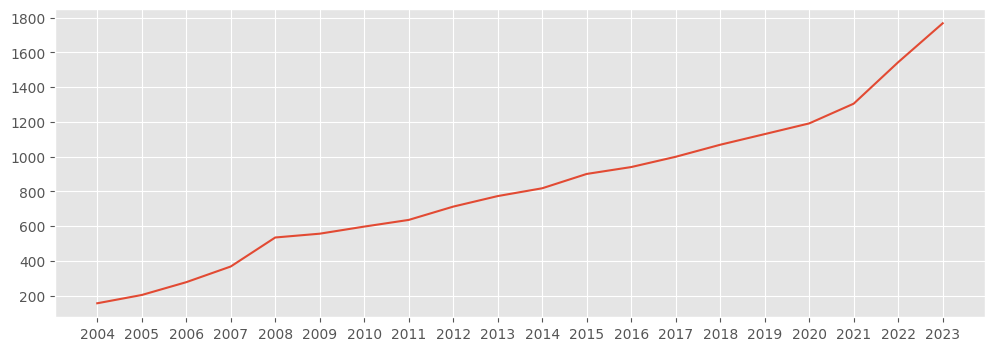

In [64]:
# we should drop really old data i.e 1970-2003
columns_to_drop = [str(year) for year in range(1985,2004)]
columns_to_drop = columns_to_drop + list(df_avg_salaries.columns[:4].values)
columns_to_drop = sorted(columns_to_drop)

df_avg_salaries = df_avg_salaries.drop(columns=columns_to_drop)

# make predictions based on average salaries
predictions = model.predict(df_avg_salaries.loc[0].values.reshape(-1,1))
df_pred = pd.DataFrame([predictions],columns=df_avg_salaries.columns)

df_avg_salaries = pd.concat([df_avg_salaries,df_pred],ignore_index=True)


fig, ax = plt.subplots(figsize=(12,4))
ax.plot(df_avg_salaries.columns,df_avg_salaries.loc[0])
plt.show()


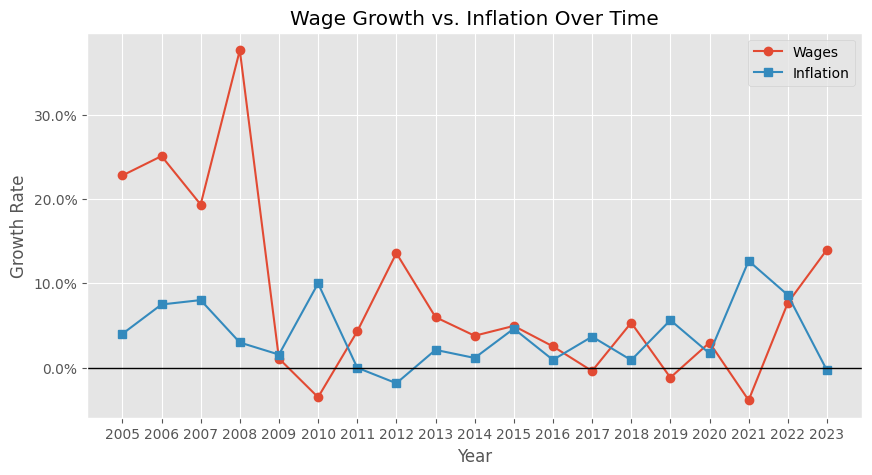

In [ ]:
# now we have median salaries data for years 2004-2023 and we should find if salaries keep up with inflation
inflation_rate_over_years = []

year_starts = list(df_price_changes.loc[0][1::12])
year_ends = list(df_price_changes.loc[0][12::12])

# calculate yearly inflation 
for i in range(len(year_ends)):
    inflation_rate_over_years.append((year_ends[i]-year_starts[i]) 
                                     / year_starts[i]  * 100 )
    

# we should convert average(or predicted median) nominal wages to real wages using CPI
wages = list(df_avg_salaries.loc[0])
real_wages = []
for idx in range(len(wages)):
    real_wages.append(wages[idx] / year_ends[idx]  * 100)

# calculate growth rate for adjusted values of wages
wage_growth_rate = calculate_growth(real_wages)

fig, ax = plt.subplots(figsize=(10,5))
years = df_avg_salaries.columns[1:]

ax.plot(years, wage_growth_rate,marker='o', label='Wages')
ax.plot(years, inflation_rate_over_years[1:-1],marker='s',label="Inflation")

# format y to beaufity values
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(decimals=1))

plt.axhline(y=0, color='black', linewidth=1)

ax.set_title("Wage Growth vs. Inflation Over Time")
ax.set_xlabel("Year")
ax.set_ylabel("Growth Rate")
plt.legend()
plt.show()

    

#### Wage Growth vs Inflation
Which years did wages kept up with inflation?  

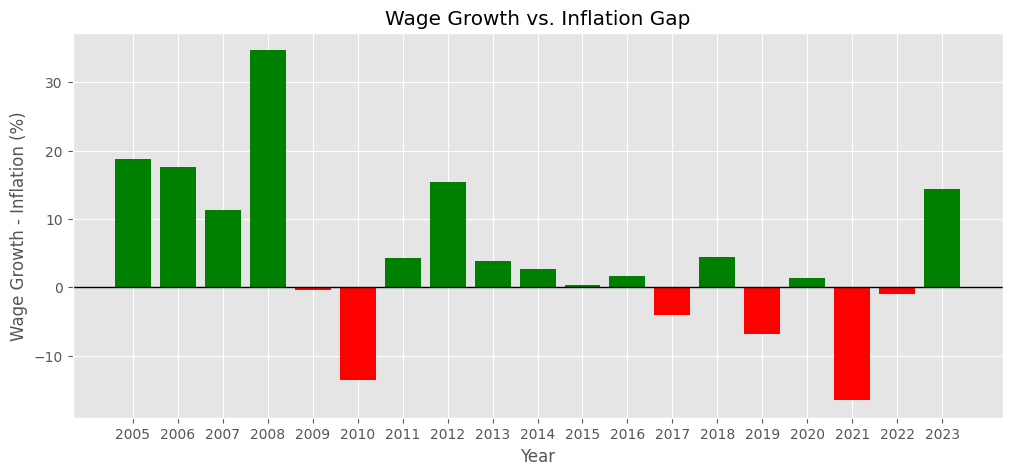

In [ ]:
gaps = np.array(wage_growth_rate) - np.array(inflation_rate_over_years[1:-1])

plt.figure(figsize=(12, 5))
plt.bar(years, gaps, color=['green' if g > 0 else 'red' for g in gaps])

plt.axhline(y=0, color='black', linewidth=1)

plt.xlabel("Year")
plt.ylabel("Wage Growth - Inflation (%)")
plt.title("Wage Growth vs. Inflation Gap")
plt.show()